# Set up environment and dependencies

In [ ]:
# !pip install tensorflow_ranking

In [ ]:
import numpy as np
import pandas as pd
import json
from PIL import Image
import requests
from io import BytesIO
from glob import glob
import os
import shutil
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import sys
import math
from typing import List

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
import tensorflow_ranking as tfr

In [ ]:
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    DATA_DIR = '/content/drive/MyDrive/FathomNet23/fathomnet-out-of-sample-detection/'
    WORKSPACE_DIR = '/content/drive/MyDrive/FathomNet23/workspace/'
else:
    raise NotImplementedError

Mounted at /content/drive


In [ ]:
from requests import get
from socket import gethostname, gethostbyname

def save_current_ipynb(outpath):
    ip = gethostbyname(gethostname()) # 172.28.0.12
    filename = get(f"http://{ip}:9000/api/sessions").json()[0]["name"]
    current_ipynb_path = os.path.join(WORKSPACE_DIR, filename)
    if not os.path.isfile(current_ipynb_path):
        raise FileNotFoundError(f'check if current notebook {filename} is located in {WORKSPACE_DIR}')
    shutil.copy(current_ipynb_path, os.path.join(outpath, filename))
    print(f'current jupiter notebook file is saved in {outpath}')

# Training data

In [ ]:
category_key = pd.read_csv(os.path.join(DATA_DIR, 'category_key.csv'))
category_key['supercat_label'] = category_key['supercat'].astype('category').cat.codes
supercat_label_per_category_id = {row['id']: row['supercat_label'] for _, row in category_key.iterrows()}

In [ ]:
train_csv = pd.read_csv(os.path.join(DATA_DIR, 'multilabel_classification', 'train.csv'))
train_csv.categories = train_csv.categories.apply(lambda x: list(map(int, json.loads(x))))
train_csv['supercats'] = train_csv.categories.apply(
    lambda x: list(set([supercat_label_per_category_id[category_id] for category_id in x])))
train_csv.head()

,id,categories,supercats
0,3b6f01ae-5bde-434d-9b06-79b269421ed6,[1],[0]
1,dce21f7c-20e5-482b-bd90-c038f8464c03,[1],[0]
2,4a7f2199-772d-486d-b8e2-b651246316b5,[1],[0]
3,3bddedf6-4ff8-4e81-876a-564d2b03b364,"[1, 9, 11, 88]","[0, 13, 6]"
4,3f735021-f5de-4168-b139-74bf2859d12a,"[1, 37, 51, 119]","[0, 13, 6]"


In [ ]:
with open(os.path.join(DATA_DIR, 'object_detection', 'train.json')) as f:
    train_json = json.load(f)
train_json_images = pd.json_normalize(train_json['images'])
train_json_images.drop(['license'], axis=1, inplace=True)
train_json_images.drop(['flickr_url'], axis=1, inplace=True)
train_json_images.drop(['id'], axis=1, inplace=True)
train_json_images['id'] = train_json_images.file_name.apply(lambda x: x.split('.png')[0])
train_json_images.drop(['file_name'], axis=1, inplace=True)

In [ ]:
train_data = train_json_images.merge(right=train_csv, how='left', left_on='id', right_on='id')
train_data.head()

,width,height,coco_url,date_captured,id,categories,supercats
0,720,368,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:34,3b6f01ae-5bde-434d-9b06-79b269421ed6,[1],[0]
1,720,368,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:38,dce21f7c-20e5-482b-bd90-c038f8464c03,[1],[0]
2,720,368,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:44,4a7f2199-772d-486d-b8e2-b651246316b5,[1],[0]
3,720,368,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-28 17:54:14,3bddedf6-4ff8-4e81-876a-564d2b03b364,"[1, 9, 11, 88]","[0, 13, 6]"
4,720,369,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-28 19:00:00,3f735021-f5de-4168-b139-74bf2859d12a,"[1, 37, 51, 119]","[0, 13, 6]"


## Examine the class label imbalance

### Categories

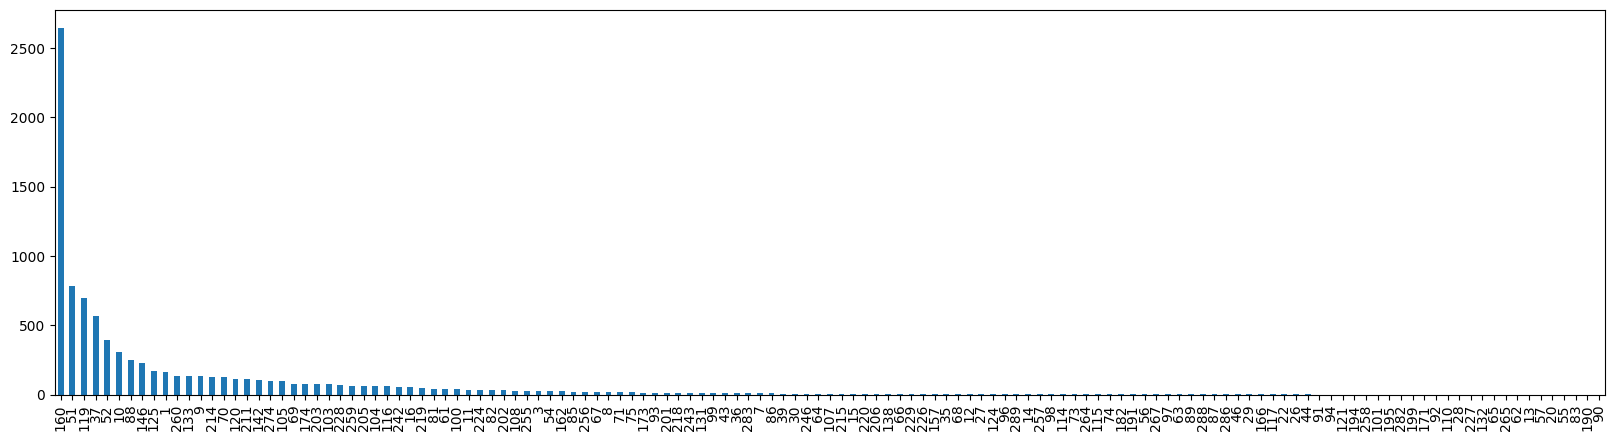

In [ ]:
num_samples_per_category = pd.value_counts(np.concatenate(train_data.categories))

plt.figure(figsize=(20, 5))
num_samples_per_category.plot(kind='bar')
plt.show()

We replace all classes with too few examples with a new class for all "underrepresented:" categories.

In [ ]:
underrepresented_categories = list(num_samples_per_category[num_samples_per_category < 10].index)

In [ ]:
train_data.categories = train_data.categories.apply(
    lambda categs: [x for x in categs if x not in underrepresented_categories])

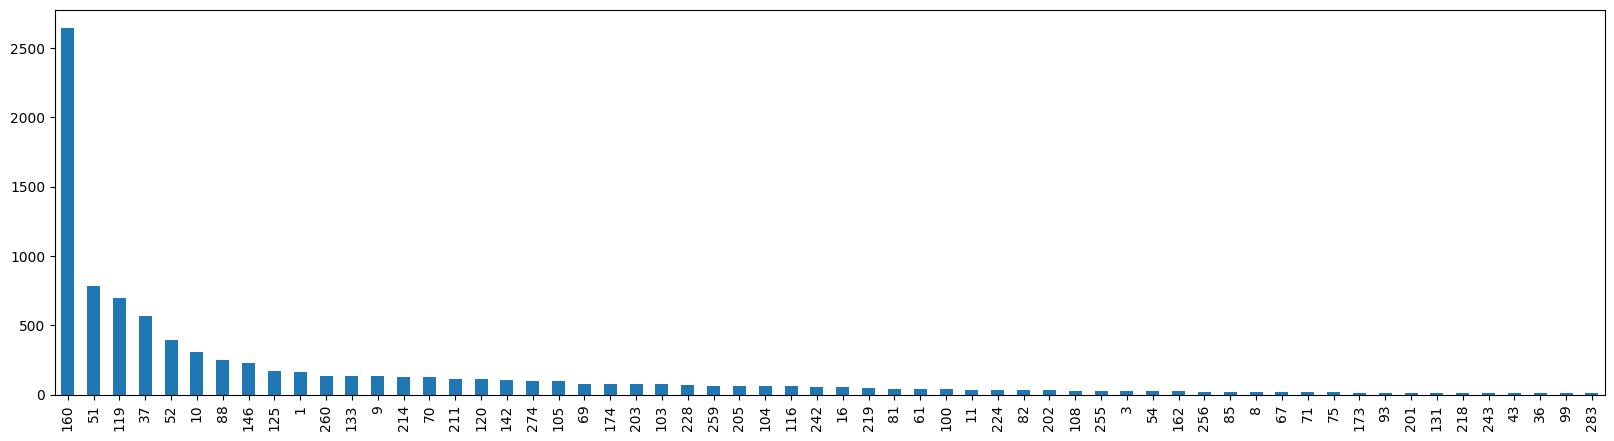

In [ ]:
num_samples_per_category = pd.value_counts(np.concatenate(train_data.categories))
num_samples_per_category.index = np.array(num_samples_per_category.index, dtype=int)

plt.figure(figsize=(20, 5))
num_samples_per_category.plot(kind='bar')
plt.show()

In [ ]:
print(f'{len(num_samples_per_category)} categories left to train a model')

60 categories left to train a model


### Supercategories

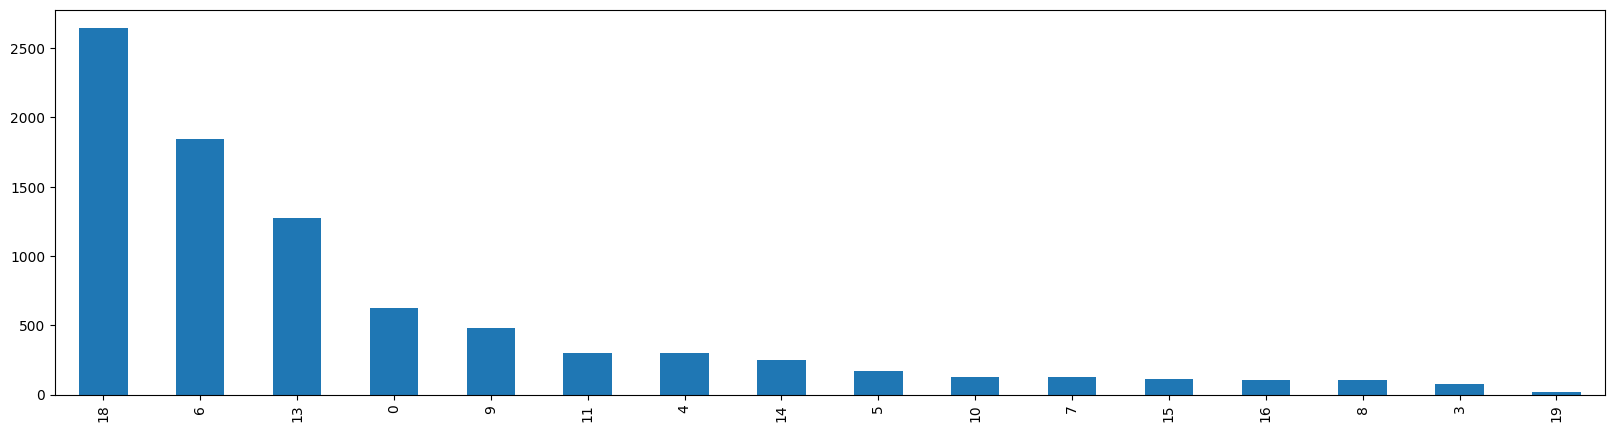

In [ ]:
num_samples_per_supercat = pd.value_counts(np.concatenate(train_data.supercats))

plt.figure(figsize=(20, 5))
num_samples_per_supercat.plot(kind='bar')
plt.show()

In [ ]:
min(num_samples_per_supercat)

19

Each supercategory contains at least 19 examples. We leave this lables without any changes.

## Example images

In [ ]:
# supercat_label2name = dict()
# for supercat_label in num_samples_per_supercat.keys():
#     supercat_name = category_key.supercat.to_numpy()[
#         category_key.index[category_key['supercat_label'] == supercat_label]][0]
#     supercat_label2name[supercat_label] = supercat_name

In [ ]:
# img_per_supercat = defaultdict(list)
# for supercat_label, supercat_name in tqdm(supercat_label2name.items()):
#     train_samples = train_data[train_data.supercats.apply(lambda x: supercat_label in x and len(x) == 1)]
#     for _, row in train_samples.sample(n=2, random_state=10219).iterrows():
#         image = Image.open(BytesIO(requests.get(row['coco_url']).content))
#         img_per_supercat[supercat_name].append(np.array(image, dtype='uint8'))

In [ ]:
# fig, axs = plt.subplots(nrows=len(img_per_supercat), ncols=2,
#                         figsize=(16, 4 * len(img_per_supercat)))
# for i, (supercat_name, images) in enumerate(img_per_supercat.items()):
#     for j, image in enumerate(images):
#         axs[i][j].imshow(image)
#         axs[i][j].set_title(supercat_name)
#         axs[i][j].axis("off")
# fig.tight_layout()
# fig.show()

# Evaluation data

In [ ]:
with open(os.path.join(DATA_DIR, 'object_detection', 'eval.json')) as f:
    eval_json = json.load(f)

eval_data = pd.json_normalize(eval_json['images'])
eval_data.drop(['license'], axis=1, inplace=True)
eval_data.drop(['flickr_url'], axis=1, inplace=True)
eval_data.drop(['id'], axis=1, inplace=True)
eval_data['id'] = eval_data.file_name.apply(lambda x: x.split('.png')[0])
eval_data.drop(['file_name'], axis=1, inplace=True)
eval_data.head()

,width,height,coco_url,date_captured,id
0,1920,1079,https://fathomnet.org/static/m3/framegrabs/Min...,2019-09-24 12:11:05,4172b65a-8b4f-4175-94e4-00187e2d5f33
1,713,425,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-15 18:44:36,9d263fd4-f786-42bf-8e0c-2d5be7c81b49
2,720,368,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-09-08 14:41:18,c114ccb9-cf89-4d98-807b-f8636477c6ca
3,718,365,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-11-07 18:52:01,95ba3acc-859b-4a99-8c30-b38a91a1be28
4,720,368,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-12-06 20:00:00,0c4bdb90-c715-4c01-81d1-aa7f49534ac7


# Preprocessing

In [ ]:
train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=True, random_state=7471)

In [ ]:
train_data.head()

,width,height,coco_url,date_captured,id,categories,supercats
1332,720,367,https://fathomnet.org/static/m3/framegrabs/Ven...,2008-01-31 18:59:04,a34a78e9-d05e-4f26-b817-6851a1be892b,[51],[6]
5530,716,370,https://fathomnet.org/static/m3/framegrabs/Ven...,2010-01-28 17:12:15,bb3de162-b031-4c8d-93ec-8e4af7744ab3,[214],[11]
5024,714,368,https://fathomnet.org/static/m3/framegrabs/Ven...,2011-11-10 21:50:48,c8aa8a87-d657-4d35-bf78-145c177910f5,[160],[18]
3756,720,366,https://fathomnet.org/static/m3/framegrabs/Ven...,2009-10-09 17:45:57,f9a54ca5-825f-43e6-b09c-c1fa2c3a97d3,[160],[18]
3667,714,368,https://fathomnet.org/static/m3/framegrabs/Ven...,2011-11-10 22:03:44,1be618ce-b240-481f-843a-ff58ca5824f7,"[146, 160]","[9, 18]"


In [ ]:
val_data.head()

,width,height,coco_url,date_captured,id,categories,supercats
3873,720,366,https://fathomnet.org/static/m3/framegrabs/Ven...,2009-10-09 19:13:15,597ead5b-a4af-4794-848a-79a36e77f534,[160],[18]
3719,720,368,https://fathomnet.org/static/m3/framegrabs/Ven...,2009-09-23 19:15:00,eaad7cae-d26c-4781-b93c-00a5ecd1fe9b,[160],[18]
2575,720,366,https://fathomnet.org/static/m3/framegrabs/Ven...,2010-01-22 18:16:42,2e084f29-cb35-4b3a-9eba-768fd1ca5912,[81],[7]
5827,1920,1080,https://fathomnet.org/static/m3/framegrabs/Doc...,2019-03-13 20:21:20,ef3e31c7-a53d-48b0-b68c-ed95b6d22bdb,[260],[14]
2401,1920,1080,https://fathomnet.org/static/m3/framegrabs/Ven...,2014-06-25 21:00:00,01ba511c-6a1b-4168-a16a-4ac86f589e99,[69],[4]


In [ ]:
categories_encoder = MultiLabelBinarizer().fit(train_data.categories)
encode_sample_categories = lambda x: categories_encoder.transform([x])[0]

supercats_encoder = MultiLabelBinarizer().fit(train_data.supercats)
encode_sample_supercats = lambda x: supercats_encoder.transform([x])[0]

In [ ]:
train_data.categories = train_data.categories.apply(encode_sample_categories)
train_data.supercats = train_data.supercats.apply(encode_sample_supercats)
train_data.head()

,width,height,coco_url,date_captured,id,categories,supercats
1332,720,367,https://fathomnet.org/static/m3/framegrabs/Ven...,2008-01-31 18:59:04,a34a78e9-d05e-4f26-b817-6851a1be892b,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
5530,716,370,https://fathomnet.org/static/m3/framegrabs/Ven...,2010-01-28 17:12:15,bb3de162-b031-4c8d-93ec-8e4af7744ab3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
5024,714,368,https://fathomnet.org/static/m3/framegrabs/Ven...,2011-11-10 21:50:48,c8aa8a87-d657-4d35-bf78-145c177910f5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
3756,720,366,https://fathomnet.org/static/m3/framegrabs/Ven...,2009-10-09 17:45:57,f9a54ca5-825f-43e6-b09c-c1fa2c3a97d3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
3667,714,368,https://fathomnet.org/static/m3/framegrabs/Ven...,2011-11-10 22:03:44,1be618ce-b240-481f-843a-ff58ca5824f7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]"


In [ ]:
val_data.categories = val_data.categories.apply(encode_sample_categories)
val_data.supercats = val_data.supercats.apply(encode_sample_supercats)
val_data.head()

,width,height,coco_url,date_captured,id,categories,supercats
3873,720,366,https://fathomnet.org/static/m3/framegrabs/Ven...,2009-10-09 19:13:15,597ead5b-a4af-4794-848a-79a36e77f534,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
3719,720,368,https://fathomnet.org/static/m3/framegrabs/Ven...,2009-09-23 19:15:00,eaad7cae-d26c-4781-b93c-00a5ecd1fe9b,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2575,720,366,https://fathomnet.org/static/m3/framegrabs/Ven...,2010-01-22 18:16:42,2e084f29-cb35-4b3a-9eba-768fd1ca5912,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
5827,1920,1080,https://fathomnet.org/static/m3/framegrabs/Doc...,2019-03-13 20:21:20,ef3e31c7-a53d-48b0-b68c-ed95b6d22bdb,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2401,1920,1080,https://fathomnet.org/static/m3/framegrabs/Ven...,2014-06-25 21:00:00,01ba511c-6a1b-4168-a16a-4ac86f589e99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


# Make tfrecord files

In [ ]:
target_image_size = (224, 224)

def make_tfrecords(data_frame: pd.DataFrame, tfrecords_dir: str, is_data_labeled: bool,
                   override_existing_tfrecords=False):
    if os.path.exists(tfrecords_dir):
        if override_existing_tfrecords:
            shutil.rmtree(tfrecords_dir)
        else:
            raise FileExistsError('tfrecords are already created; '
                                  'to override existing files set `override_existing_tfrecords=True`')
    os.makedirs(tfrecords_dir)

    data_buffer = []
    num_samples_per_file = 500
    num_tfrecords_saved = 0
    for i, (index, row) in tqdm(enumerate(data_frame.iterrows())):
        sample = dict()
        sample['id'] = tf.compat.as_bytes(row['id'])

        image_url = row['coco_url']
        image = Image.open(BytesIO(requests.get(image_url).content))
        image = image.resize(target_image_size)
        sample['image'] = tf.image.encode_png(np.array(image, dtype='uint8')).numpy()
        if is_data_labeled:
            sample['categories'] = np.array(row['categories'], dtype=np.float32)
            sample['supercats'] = np.array(row['supercats'], dtype=np.float32)
        data_buffer.append(sample)

        if len(data_buffer) == num_samples_per_file or i == (len(data_frame) - 1):
            tfrecord_outpath = os.path.join(tfrecords_dir, f'{num_tfrecords_saved:03d}.tfrecord')
            print(tfrecord_outpath)

            with tf.io.TFRecordWriter(tfrecord_outpath) as tfrecord_writer:
                for sample in data_buffer:
                    feature=dict(
                        image=tf.train.Feature(bytes_list=tf.train.BytesList(value=[sample['image']])),
                        id=tf.train.Feature(bytes_list=tf.train.BytesList(value=[sample['id']]))
                    )
                    if is_data_labeled:
                        feature.update(dict(
                            categories=tf.train.Feature(float_list=tf.train.FloatList(value=sample['categories'])),
                            supercats=tf.train.Feature(float_list=tf.train.FloatList(value=sample['supercats'])),
                        ))
                    record_bytes = tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()
                    tfrecord_writer.write(record_bytes)

            num_tfrecords_saved += 1
            data_buffer = []  # reset data buffer

## Training data

In [ ]:
train_tfrecords_dir = os.path.join(WORKSPACE_DIR, 'data', 'train')
if os.path.isdir(train_tfrecords_dir):
    print('train data already exist, skip creating tfrecord data')
else:
    make_tfrecords(train_data, train_tfrecords_dir, is_data_labeled=True)

train data already exist, skip creating tfrecord data


## Validation data

In [ ]:
val_tfrecords_dir = os.path.join(WORKSPACE_DIR, 'data', 'validation')
if os.path.isdir(val_tfrecords_dir):
    print('validation data already exist, skip creating tfrecord data')
else:
    make_tfrecords(val_data, val_tfrecords_dir, is_data_labeled=True)

validation data already exist, skip creating tfrecord data


## Evaluation data

In [ ]:
with open(os.path.join(DATA_DIR, 'object_detection', 'eval.json')) as f:
    eval_json = json.load(f)
eval_data = pd.json_normalize(eval_json['images'])
eval_data['id'] = eval_data.file_name.apply(lambda x: x.split('.png')[0])
eval_data = pd.DataFrame(eval_data[['id', 'coco_url']])
eval_data.head()

,id,coco_url
0,4172b65a-8b4f-4175-94e4-00187e2d5f33,https://fathomnet.org/static/m3/framegrabs/Min...
1,9d263fd4-f786-42bf-8e0c-2d5be7c81b49,https://fathomnet.org/static/m3/framegrabs/Ven...
2,c114ccb9-cf89-4d98-807b-f8636477c6ca,https://fathomnet.org/static/m3/framegrabs/Tib...
3,95ba3acc-859b-4a99-8c30-b38a91a1be28,https://fathomnet.org/static/m3/framegrabs/Ven...
4,0c4bdb90-c715-4c01-81d1-aa7f49534ac7,https://fathomnet.org/static/m3/framegrabs/Ven...


In [ ]:
eval_tfrecords_dir = os.path.join(WORKSPACE_DIR, 'data', 'evaluation')

if os.path.isdir(eval_tfrecords_dir):
    print('evaluation data already exists, skip creating tfrecord data')
else:
    make_tfrecords(eval_data, eval_tfrecords_dir, is_data_labeled=False)

evaluation data already exists, skip creating tfrecord data


---
********* Run until here with CPU accelerator if you need to create tfrecord files *********

---

# Train model

In [ ]:
model_name = time.strftime("%Y%m%d_%H%M%S")
model_path = os.path.join(WORKSPACE_DIR, 'models', model_name)
os.makedirs(model_path)
model_path

'/content/drive/MyDrive/FathomNet23/workspace/models/20230523_174604'

## Prepare TF datasets

In [ ]:
CATEGORIES_SHAPE = train_data['categories'].to_numpy()[0].shape
SUPERCATS_SHAPE = train_data['supercats'].to_numpy()[0].shape

# Read the data back out.
def decode_tfrecord(record_bytes):
    parsed_example = tf.io.parse_single_example(
        # Data
        record_bytes,

        # Schema
        dict(
            image=tf.io.FixedLenFeature([], dtype=tf.string),
            categories=tf.io.FixedLenFeature(CATEGORIES_SHAPE, dtype=tf.float32),
            # supercats=tf.io.FixedLenFeature(SUPERCATS_SHAPE, dtype=tf.float32),
        )
    )
    parsed_example['image'] = tf.image.decode_image(parsed_example['image'], channels=3)
    return parsed_example

In [ ]:
BATCH_SIZE = 256

def get_dataset_for_model_fit(tfrecords_dir: str, shuffle: bool):
    file_pattern = os.path.join(tfrecords_dir, '*.tfrecord')
    dataset = tf.data.Dataset.list_files(file_pattern, shuffle=True, seed=28796)
    dataset = dataset.interleave(lambda fn: tf.data.TFRecordDataset(fn).map(decode_tfrecord),
                                 cycle_length=len(glob(file_pattern)),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(1000, seed=981, reshuffle_each_iteration=True)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    # dataset = dataset.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(transform_data_for_model_fit, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


def normalize_image(data_batch):
    images_batch = data_batch['image']
    images_batch = tf.cast(images_batch, tf.float32)
    images_batch = images_batch / 255.
    data_batch['image'] = images_batch
    return data_batch


def transform_data_for_model_fit(data_batch):
    inputs = {k: v for k, v in data_batch.items() if k in ['image', 'id']}
    # targets = {k: v for k, v in data_batch.items() if k in ['categories', 'supercats']}
    targets = {k: v for k, v in data_batch.items() if k in ['categories']}
    return inputs, targets

In [ ]:
train_dataset = get_dataset_for_model_fit(train_tfrecords_dir, shuffle=True)
val_dataset = get_dataset_for_model_fit(val_tfrecords_dir, shuffle=False)

## Initialize model

In [ ]:
initial_categories_bias = np.zeros(CATEGORIES_SHAPE[0])
num_categories_samples = sum(num_samples_per_category)
for category in num_samples_per_category.index:
    pos = num_samples_per_category[category]
    neg = num_categories_samples - pos
    category_index = np.where(categories_encoder.transform([[category]])[0] > 0)[0][0]
    initial_categories_bias[category_index] = np.log(pos / neg)

In [ ]:
# initial_supercats_bias = np.zeros(SUPERCATS_SHAPE[0])
# num_supercats_samples = sum(num_samples_per_supercat)
# for supercat in num_samples_per_supercat.index:
#     pos = num_samples_per_supercat[supercat]
#     neg = num_supercats_samples - pos
#     supercat_index = np.where(supercats_encoder.transform([[supercat]])[0] > 0)[0][0]
#     initial_supercats_bias[supercat_index] = np.log(pos / neg)

In [ ]:
inputs = tf.keras.layers.Input(shape=(*target_image_size, 3), name='image')

x = tf.keras.layers.RandomFlip("horizontal")(inputs)
x = tf.keras.layers.RandomRotation(0.05)(x)

base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(*target_image_size, 3),
    include_preprocessing=True)

x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

categories = tf.keras.layers.Dense(CATEGORIES_SHAPE[0], activation='sigmoid', name='categories',
                                   bias_initializer=tf.keras.initializers.Constant(initial_categories_bias))(x)
# supercats = tf.keras.layers.Dense(SUPERCATS_SHAPE[0], activation='sigmoid', name='supercats',
#                                   bias_initializer=tf.keras.initializers.Constant(initial_supercats_bias))(x)
model = tf.keras.Model(inputs=inputs, outputs=[categories])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                             

## Fit the weights

### Fine tuning stage 1

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss={
        'categories': tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
        # 'supercats': tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    },
    metrics={
        'categories': [
            tfr.keras.metrics.MeanAveragePrecisionMetric(topn=20, name='MAP@20'),
            tf.keras.metrics.BinaryAccuracy()
        ],
        # 'supercats': tf.keras.metrics.BinaryAccuracy(),
    },
)

In [ ]:
fine_tuning1_history = model.fit(train_dataset, validation_data=val_dataset,
                                 steps_per_epoch=len(train_data) // BATCH_SIZE,
                                 validation_steps=len(val_data) // BATCH_SIZE,
                                 epochs=15)

Epoch 1/15
18/18 [==============================] - 40s 732ms/step - loss: 0.2656 - MAP@20: 0.5448 - binary_accuracy: 0.9777 - val_loss: 0.2412 - val_MAP@20: 0.6294 - val_binary_accuracy: 0.9812
Epoch 2/15
18/18 [==============================] - 12s 709ms/step - loss: 0.2428 - MAP@20: 0.6280 - binary_accuracy: 0.9810 - val_loss: 0.2373 - val_MAP@20: 0.6699 - val_binary_accuracy: 0.9817
Epoch 3/15
18/18 [==============================] - 10s 576ms/step - loss: 0.2385 - MAP@20: 0.6765 - binary_accuracy: 0.9818 - val_loss: 0.2354 - val_MAP@20: 0.6896 - val_binary_accuracy: 0.9824
Epoch 4/15
18/18 [==============================] - 13s 727ms/step - loss: 0.2370 - MAP@20: 0.6895 - binary_accuracy: 0.9824 - val_loss: 0.2341 - val_MAP@20: 0.6953 - val_binary_accuracy: 0.9828
Epoch 5/15
18/18 [==============================] - 12s 657ms/step - loss: 0.2366 - MAP@20: 0.7029 - binary_accuracy: 0.9826 - val_loss: 0.2348 - val_MAP@20: 0.7106 - val_binary_accuracy: 0.9830
Epoch 6/15
18/18 [=======

### Fine tuning stage 2

In [ ]:
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

In [ ]:
# we chose to train the top block
for layer in base_model.layers[:76]:
   layer.trainable = False
for layer in base_model.layers[76:]:
   layer.trainable = True

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=1e-4),
    loss={
        'categories': tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
        # 'supercats': tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    },
    metrics={
        'categories': [
            tfr.keras.metrics.MeanAveragePrecisionMetric(topn=20, name='MAP@20'),
            tf.keras.metrics.BinaryAccuracy()
        ],
        # 'supercats': tf.keras.metrics.BinaryAccuracy(),
    },
)

In [ ]:
fine_tuning2_history = model.fit(train_dataset, validation_data=val_dataset,
                                 steps_per_epoch=len(train_data) // BATCH_SIZE,
                                 validation_steps=len(val_data) // BATCH_SIZE,
                                 epochs=30)

Epoch 1/30
18/18 [==============================] - 66s 1s/step - loss: 0.2685 - MAP@20: 0.5819 - binary_accuracy: 0.9738 - val_loss: 0.2451 - val_MAP@20: 0.6680 - val_binary_accuracy: 0.9814
Epoch 2/30
18/18 [==============================] - 19s 1s/step - loss: 0.2492 - MAP@20: 0.6357 - binary_accuracy: 0.9811 - val_loss: 0.2412 - val_MAP@20: 0.6610 - val_binary_accuracy: 0.9815
Epoch 3/30
18/18 [==============================] - 21s 1s/step - loss: 0.2423 - MAP@20: 0.6683 - binary_accuracy: 0.9816 - val_loss: 0.2378 - val_MAP@20: 0.6828 - val_binary_accuracy: 0.9824
Epoch 4/30
18/18 [==============================] - 18s 1s/step - loss: 0.2378 - MAP@20: 0.6960 - binary_accuracy: 0.9827 - val_loss: 0.2356 - val_MAP@20: 0.7009 - val_binary_accuracy: 0.9828
Epoch 5/30
18/18 [==============================] - 19s 1s/step - loss: 0.2359 - MAP@20: 0.7082 - binary_accuracy: 0.9831 - val_loss: 0.2342 - val_MAP@20: 0.7105 - val_binary_accuracy: 0.9833
Epoch 6/30
18/18 [======================

## Post-process trained model

In [ ]:
model.save(os.path.join(model_path, 'model.kerasmodel.h5'))

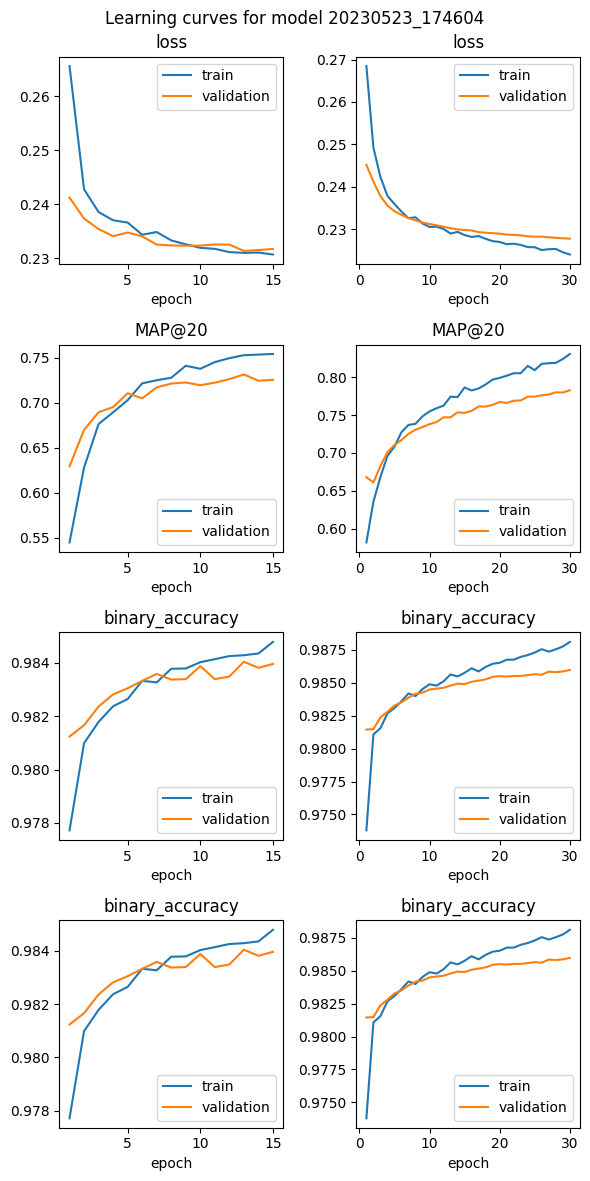

In [ ]:
history_keys_to_show = ['loss', 'MAP@20', 'binary_accuracy', 'binary_accuracy']
first_epoch_to_show = 0

fig, axs = plt.subplots(ncols=2, nrows=len(history_keys_to_show),
                        figsize=(6, 3 * len(history_keys_to_show)))
for j, history in enumerate([fine_tuning1_history, fine_tuning2_history]):
    for i, hist_key in enumerate(history_keys_to_show):
        hist_train_vals = history.history[hist_key][first_epoch_to_show:]
        hist_validation_vals = history.history[f'val_{hist_key}'][first_epoch_to_show:]
        x = np.array(list(range(first_epoch_to_show, len(history.history[hist_key])))) + 1

        axs[i][j].plot(x, hist_train_vals, label='train')
        axs[i][j].plot(x, hist_validation_vals, label='validation')
        axs[i][j].legend()
        axs[i][j].set_xlabel('epoch')
        axs[i][j].set_title(f'{hist_key}')
fig.suptitle(f'Learning curves for model {model_name}')
fig.tight_layout()
fig.savefig(os.path.join(model_path, f'{model_name}_learning_curves.png'))
fig.show()

# Submission

## Score all evaluation samples

In [ ]:
# Read the data back out.
def decode_tfrecord_for_evaluation(record_bytes):
    parsed_example = tf.io.parse_single_example(
        # Data
        record_bytes,

        # Schema
        dict(
            id=tf.io.FixedLenFeature([], dtype=tf.string),
            image=tf.io.FixedLenFeature([], dtype=tf.string),
        )
    )
    parsed_example['image'] = tf.image.decode_image(parsed_example['image'], channels=3)
    return parsed_example

In [ ]:
def get_dataset_for_evaluation(tfrecords_dir: str):
    file_pattern = os.path.join(tfrecords_dir, '*.tfrecord')
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(lambda fn: tf.data.TFRecordDataset(fn).map(decode_tfrecord_for_evaluation))
    dataset = dataset.batch(BATCH_SIZE)
    # dataset = dataset.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
eval_dataset = get_dataset_for_evaluation(eval_tfrecords_dir)

In [ ]:
scored_eval_samples = dict()
for data_batch in tqdm(eval_dataset.as_numpy_iterator()):
    pred = model.predict_on_batch(data_batch['image'])
    for i in range(len(data_batch['image'])):
        sample_scores = dict(categories=pred[i].tolist())
        # sample_scores = dict()
        # for output_index, output_name in enumerate(model.output_names):
        #     sample_scores[output_name] = pred[output_index][i].tolist()
        sample_scores['osd'] = 1 - max(sample_scores['categories'])
        id=tf.compat.as_str(data_batch['id'][i])
        scored_eval_samples[id] = sample_scores

41it [00:26,  1.77it/s]

In [ ]:
with open(os.path.join(model_path, "scored_eval_samples.json"), "w") as f:
    json.dump(scored_eval_samples, f)

## Get ranked predictions

In [ ]:
all_scores_per_category = defaultdict(list)
# all_scores_per_supercat = defaultdict(list)

for id, scores_per_output in tqdm(scored_eval_samples.items()):
    # categories
    ranked_classes = np.argsort(scores_per_output['categories'])[::-1]
    ranked_predicted_categories = []
    for class_index in ranked_classes:
        class_one_hot_array = np.zeros(len(ranked_classes))
        class_one_hot_array[class_index] = 1.0
        predicted_category = categories_encoder.inverse_transform(np.array([class_one_hot_array]))
        predicted_category = predicted_category[0][0]
        all_scores_per_category[predicted_category].append(scores_per_output["categories"][class_index])
        ranked_predicted_categories.append(predicted_category)
    scored_eval_samples[id]['ranked_predicted_categories'] = ranked_predicted_categories

    # # supercategories
    # ranked_supercats = np.argsort(scores_per_output['supercats'])[::-1]
    # ranked_predicted_supercats = []
    # for supercat_index in ranked_supercats:
    #     supercat_one_hot_array = np.zeros(len(ranked_supercats))
    #     supercat_one_hot_array[supercat_index] = 1.0
    #     predicted_supercat = supercats_encoder.inverse_transform(np.array([supercat_one_hot_array]))
    #     predicted_supercat = predicted_supercat[0][0]
    #     all_scores_per_supercat[predicted_supercat].append(scores_per_output['supercats'][supercat_index])
    #     ranked_predicted_supercats.append(predicted_supercat)
    # scored_eval_samples[id]['ranked_predicted_supercats'] = ranked_predicted_supercats

## Examine the score distributions

### Categories

In [ ]:
ordered_category_labels = sorted([(int(v), k) for v, k in num_samples_per_category.items()],
                                 reverse=True, key=lambda x: x[1])

num_hist_per_row = 10
nrows = math.ceil(len(all_scores_per_category) / num_hist_per_row)
fig, axs = plt.subplots(ncols=num_hist_per_row, nrows=nrows,
                        figsize=(1.5 * num_hist_per_row, 1.5 * nrows))
for i, (category_encoding, num_train_samples) in enumerate(ordered_category_labels):
    ax = axs[i // num_hist_per_row, i % num_hist_per_row]
    scores = all_scores_per_category[category_encoding]
    ax.hist(scores, color="purple", bins=30, density=True, cumulative=True)
    ax.set_xlim([-0.05, 1.05])
    ax.set_yticks([])
    ax.tick_params(axis='both', which='major', labelsize=8)
    category_part = num_train_samples / sum(num_samples_per_category)
    ax.set_title(f'{category_encoding} ({category_part:.1%} train samples)', fontsize=8)
fig.suptitle(f'Category probabilities for model {model_name}')
fig.tight_layout(rect=(0, 0, 1, 0.98))
fig.savefig(os.path.join(model_path, f'{model_name}_category_scores.png'))
fig.show()

In [ ]:
max_category_scores = []
for id, sample_with_preds in scored_eval_samples.items():
    max_category_scores.append(max(sample_with_preds['categories']))

plt.hist(max_category_scores, bins=30)
plt.xlim([-0.05, 1.05])
plt.title(f'Highest category probability \n over all evaluation samples for model {model_name}')
plt.savefig(os.path.join(model_path, f'{model_name}_max_category_scores.png'))
plt.show()

### Supercategories

In [ ]:
# ordered_supercat_labels = sorted([(int(v), k) for v, k in num_samples_per_supercat.items()],
#                                  reverse=True, key=lambda x: x[1])

# num_hist_per_row = 8
# nrows = math.ceil(len(all_scores_per_supercat) / num_hist_per_row)
# fig, axs = plt.subplots(ncols=num_hist_per_row, nrows=nrows,
#                         figsize=(1.5 * num_hist_per_row, 1.5 * nrows))
# for i, (supercat_encoding, num_train_samples) in enumerate(ordered_supercat_labels):
#     ax = axs[i // num_hist_per_row, i % num_hist_per_row]
#     scores = all_scores_per_supercat[supercat_encoding]
#     ax.hist(scores, color="purple", bins=30, density=True, cumulative=True)
#     ax.set_xlim([-0.05, 1.05])
#     ax.set_yticks([])
#     ax.tick_params(axis='both', which='major', labelsize=8)
#     supercat_part = num_train_samples / sum(num_samples_per_supercat)
#     ax.set_title(f'{supercat_encoding} ({supercat_part:.1%} train samples)', fontsize=8)
# fig.suptitle(f'Supercategory probabilities for model {model_name}')
# fig.tight_layout(rect=(0, 0, 1, 0.98))
# fig.savefig(os.path.join(model_path, f'{model_name}_supercategory_scores.png'))
# fig.show()

## Post-process predicted super categories

In [ ]:
# all_supercats = np.array(list(set(category_key.supercat_label)))
# train_supercats = np.array(list(set(num_samples_per_supercat.keys())))
# only_eval_supercats = np.setdiff1d(all_supercats, train_supercats)

In [ ]:
# all_categories = np.array(list(set(category_key.id)))
# train_categories = np.array(list(set(num_samples_per_category.keys())))
# only_eval_categories = np.setdiff1d(all_categories, train_categories)

In [ ]:
# only_eval_categories_per_supercat = defaultdict(list)
# for category_id in only_eval_categories:
#     only_eval_categories_per_supercat[supercat_label_per_category_id[category_id]].append(category_id)

In [ ]:
# supercat_threshold = 0.5

# for id, eval_sample in tqdm(scored_eval_samples.items()):
#     supercat_indexes_to_sample = np.where(np.array(eval_sample['supercats']) > supercat_threshold)[0]
#     if len(supercat_indexes_to_sample) == 0:
#         supercats_to_sample = only_eval_supercats
#     else:
#         supercats_to_sample = []
#         for supercat_index in supercat_indexes_to_sample:
#             supercat_one_hot_array = np.zeros(len(eval_sample['supercats']))
#             supercat_one_hot_array[supercat_index] = 1.0
#             predicted_supercat = supercats_encoder.inverse_transform(np.array([supercat_one_hot_array]))
#             predicted_supercat = predicted_supercat[0][0]
#             supercats_to_sample.append(predicted_supercat)
    
#     category_groups_to_sample = [np.array(only_eval_categories_per_supercat[supercat_id])
#                                  for supercat_id in supercats_to_sample]
#     sampled_categories = np.block(category_groups_to_sample)
#     np.random.shuffle(sampled_categories)

#     num_categories_to_add = min(int(20 * eval_sample['osd']), len(sampled_categories))
#     categories_to_keep = list(eval_sample['ranked_predicted_categories'][:20 - num_categories_to_add])
#     categories_to_add = list(sampled_categories[:num_categories_to_add])

#     eval_sample['ranked_predicted_categories'] = categories_to_keep + categories_to_add
#     assert len(eval_sample['ranked_predicted_categories']) == 20